In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-category-dataset/News_Category_Dataset_v2.json


# The task

Text classification datasets are used to categorize natural language texts according to content. For example, think **classifying news articles by topic**, or classifying book reviews based on a positive or negative response. Text classification is also helpful for language detection, organizing customer feedback, and fraud detection.

**Category classification**, for news, is a text classification problem. The goal is to assign one category to a news article.

![task](https://miro.medium.com/max/700/1*HgXA9v1EsqlrRDaC_iORhQ.png)

In [2]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torch.utils.data import DataLoader, Dataset
from torch import nn
import pandas as pd
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import seaborn as sns

import nltk

## Read the data

Data is an json file, each object has 6 columns. We can read the file with pandas and create its DataFrame

In [3]:
data = pd.read_json("../input/news-category-dataset/News_Category_Dataset_v2.json", lines=True)
data.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


## Remove columns that we can ignore

For our purpose we can ignore columns like authors or link. We can also define a new column named "total_text" that represents the concatenation between headline and short_description fields.

In [5]:
def preprocess_data(data):
    data["total_text"] = data["headline"] + "\n" + data["short_description"]
    data.drop(["authors", "link", "date", "headline", "short_description"], axis=1, inplace=True)
    return data

In [6]:
data = preprocess_data(data)
data.head()

,category,total_text
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...


In [7]:
data.values[0]

array(['CRIME',
       'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV\nShe left her husband. He killed their children. Just another day in America.'],
      dtype=object)

## Categories distribution

We can list all category classes and show their distribution over the dataset.

['CRIME' 'ENTERTAINMENT' 'WORLD NEWS' 'IMPACT' 'POLITICS' 'WEIRD NEWS'
 'BLACK VOICES' 'WOMEN' 'COMEDY' 'QUEER VOICES' 'SPORTS' 'BUSINESS'
 'TRAVEL' 'MEDIA' 'TECH' 'RELIGION' 'SCIENCE' 'LATINO VOICES' 'EDUCATION'
 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS'
 'WELLNESS' 'PARENTING' 'HOME & LIVING' 'STYLE & BEAUTY' 'DIVORCE'
 'WEDDINGS' 'FOOD & DRINK' 'MONEY' 'ENVIRONMENT' 'CULTURE & ARTS']


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='category', ylabel='count'>

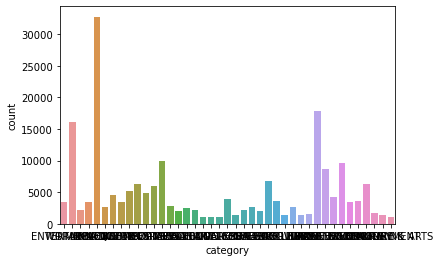

In [8]:
print(data["category"].unique())
sns.countplot(data["category"])

## Change target values 

We convert string classes to integer classes for the training step

In [9]:
c = list(data["category"].unique())

def sparse_categories(category):
    return c.index(category)

data["category"] = data["category"].apply(sparse_categories)
data.head()

,category,total_text
0,0,There Were 2 Mass Shootings In Texas Last Week...
1,1,Will Smith Joins Diplo And Nicky Jam For The 2...
2,1,Hugh Grant Marries For The First Time At Age 5...
3,1,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,1,Julianna Margulies Uses Donald Trump Poop Bags...


## Attention is All you Need

![huggingface](https://huggingface.co/front/assets/huggingface_logo.svg)

Now we can start the hot step. We install the transformers library (https://huggingface.co/transformers/). This famous library contains all transformer-based architecture implementations like BERT, BORT ecc...

For this task we use Small-Bert Model, a transformer based language model developed by Google, it represents the SOTA in a lot of NLP tasks. You can find more information at this link (https://huggingface.co/google/bert_uncased_L-4_H-512_A-8).

In [10]:
!pip install transformers

In [11]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("google/bert_uncased_L-4_H-512_A-8")

bert = AutoModel.from_pretrained("google/bert_uncased_L-4_H-512_A-8")

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116M [00:00<?, ?B/s]

### Train, Test and Validation Sets

Now we split dataset in three subset in order to create train, test and validation set.



In [12]:
# shuffling the data
data = shuffle(data)

# splitting data in train and val
train_X, val_X, train_Y, val_Y = train_test_split(data.drop("category", axis=1), data["category"], test_size = 0.3)

# splitting data in train and test
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size = 0.2)

In [13]:
train_X.sample(3)

,total_text
177999,"What's Your Strategy for Happiness?\nYes, we a..."
31018,The Big Moves This Past Year In The Fight Agai...
7089,The Cast Of ‘Incredibles 2’ Is Incredibly Good...


### Dataset Object (PyTorch)

https://pytorch.org/docs/stable/data.html

In [14]:
class TextDataset(Dataset):
  def __init__(self, ids, texts, targets, tokenizer, max_len):
    self.ids = ids
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __getitem__(self, idx):
    id = self.ids[idx]
    text = self.texts[idx]
    label = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )

    return {
      'id': torch.tensor(id, dtype=torch.long),
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'],
      'label': torch.tensor(label, dtype=torch.int)
    }

  def __len__(self):
    return len(self.texts)

In [15]:
MAX_LEN = 128
BATCH_SIZE = 32
TEST_BATCH_SIZE = 128


train_dataset = TextDataset(
  texts=train_X.total_text.to_numpy(),
  targets=train_Y.to_numpy(),
  ids=train_X.index.to_numpy(),
  tokenizer=tokenizer,
  max_len=MAX_LEN
)

val_dataset = TextDataset(
  texts=val_X.total_text.to_numpy(),
  targets=val_Y.to_numpy(),
  ids=val_X.index.to_numpy(),
  tokenizer=tokenizer,
  max_len=MAX_LEN
)

test_dataset = TextDataset(
  texts=test_X.total_text.to_numpy(),
  targets=test_Y.to_numpy(),
  ids=test_X.index.to_numpy(),
  tokenizer=tokenizer,
  max_len=MAX_LEN
)



In [16]:
train_dataloader =  DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)
val_dataloader =  DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)
test_dataloader =  DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, num_workers=0, shuffle=True)

## Classifier Model

![classifier](https://miro.medium.com/max/1972/1*84bxdoawb55WogfXSV2rUQ.png)

Our Text Classifier Model has the following architecture:

* Bert Encoding Layer
* Dropout Layer (default 0.3)
* Feed-Forward Net for Output Layer (num of classes)

**We don't apply softmax function on the output because in PyTorch the softmax is computed from the CrossEntropy Loss function.**

In [17]:
class TextClassifier(nn.Module):
  def __init__(self, n_classes, bert_model, dropout=0.3):
    super(TextClassifier, self).__init__()
    self.bert = bert_model
    self.drop = nn.Dropout(dropout)
    self.out = nn.Linear(bert_model.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask = attention_mask
    )
    
    output = self.drop(pooled_output[0][:, 0, :])
    return self.out(output)

  def save_pretrained(self, path):
    self.bert.save_pretrained(path)

## Evaluation Function

In [18]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def eval_model(model, data_loader, loss_fn, device):
  model = model.eval()
  losses = []
  predictions = []
  all_predictions , true_labels, ids = [], [], []
  correct_predictions = 0

  with torch.no_grad():
    
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      labels = d["label"].to(device)
      attention_mask = d["attention_mask"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels.long())
      losses.append(loss.item())
      correct_predictions += torch.sum(preds == labels)
      all_predictions.append(preds.cpu().data)
      true_labels.append(labels.cpu().data) 
      ids.append(d["id"].cpu().data)
  
  all_predictions = np.concatenate(all_predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)
  predictions = {"id":ids,"preds":all_predictions,"exact":true_labels}

  
  f1 = f1_score(true_labels, all_predictions, np.unique(all_predictions),average="macro")
  precision = precision_score(true_labels, all_predictions,labels=np.unique(all_predictions) ,average="macro")
  recall = recall_score(true_labels, all_predictions, labels=np.unique(all_predictions),average="macro")
  accuracy = accuracy_score(true_labels,all_predictions)

  
  
  return accuracy, f1

## Train function 

In [19]:
from tqdm import tqdm

def train(
  model,
  epochs,
  train_data_loader,
  val_data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler):

  model = model.train()

  for e in range(epochs):
    all_predictions , true_labels = [], []
    correct_predictions = 0
    losses = []

    for d in tqdm(train_data_loader):
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels.long())

      all_predictions.append(preds.cpu().data)
      true_labels.append(labels.cpu().data) 

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
      loss.backward()
        
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      
      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()

    all_predictions = np.concatenate(all_predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    f1 = f1_score(true_labels, all_predictions,labels=np.unique(all_predictions),average="macro")
    precision = precision_score(true_labels, all_predictions,labels=np.unique(all_predictions) ,average="macro")
    recall = recall_score(true_labels, all_predictions, labels=np.unique(all_predictions),average="macro")
    accuracy = accuracy_score(true_labels,all_predictions)
    print(f"Epoch: {e + 1} Accuracy: {accuracy} F1: {f1}" )

    val_acc, val_f1 = eval_model(model, val_dataloader, loss_fn, device)
    print(f"Validation Accuracy: {val_acc} F1: {val_f1}" )

  return accuracy

## Model instantiation

Now we can instantiate our classifier and set-up the loss function, the optimizer and the scheduler (https://huggingface.co/transformers/main_classes/optimizer_schedules.html). We choose AdamW like optimizer with a linear schedule with warmup and the CrossEntropyLoss.

In [20]:
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule_with_warmup

model = TextClassifier(len(c), bert, 0.4) 
model = model.to(device)
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dataloader) * EPOCHS
warmup_step = int(len(train_dataloader)/2) 

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warmup_step,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

## **Now we can finnaly train our model**

In [ ]:
train(model=model, epochs=EPOCHS, train_data_loader=train_dataloader, val_data_loader=val_dataloader, 
      loss_fn=loss_fn, optimizer=optimizer, device=device, scheduler=scheduler)

 45%|████▌     | 1592/3515 [02:27<02:55, 10.97it/s]

## Evaluate the model on test set

Measure Accuracy and F1-measure over the test-set

In [ ]:
test_acc, test_f1 = eval_model(model, test_dataloader, loss_fn, device)
